# Bias Buccaneers Image Recognition Challenge: Quickstart

This notebook will introduce you to the data and describe a workflow to train and evaluate a baseline model on it.

## Initial Setup

We start with loading the required packages.

In [14]:
# !pip install tensorflow
import numpy as np
import pandas as pd
import json
import os

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50

In [15]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#!unzip /content/drive/MyDrive/data_bb1_img_recognition -d /content/

## Load the Data

Make sure to download and uncompress the data (`data_bb1_img_recognition.zip`) in the folder you're working off of.

We first load the file containing the labels, binarize labels of each of the three classes as a numpy array and store them as a list.

In [18]:
# load data
LOADPATH = './train/'
SAVEPATH = './models/limited/'
df = pd.read_csv(LOADPATH+'labels.csv')
df_labeled = df[df["skin_tone"].notna()] # take only labeled data

# filter for verified humans
df_labeled = df_labeled[df_labeled['real_face'] == 1]


In [19]:
df_labeled.shape

(6019, 5)

In [20]:

# Converting labels to np array
cat = ['skin_tone','gender','age']
lbs = [LabelBinarizer() for i in range(3)]
base_Y = []
for i in range(3):
    lab = lbs[i].fit_transform(df_labeled[cat[i]])
    if lab.shape[1]==1:
        base_Y.append(np.hstack((1-lab,lab)))
    else:
        base_Y.append(lab)

We then load the images under the training set and convert them to numpy arrays. This may take a while.

In [21]:
length = width = 64 # size for each input image, increase if you want

In [22]:
# loading and converting data into np array
print("Loading images")

base_nn = df_labeled.shape[0]
all_imgs = [image.load_img(LOADPATH+df_labeled.iloc[i]['name'], target_size=(length,width)) for i in range(base_nn)]

print("Converting images to np array")
base_X = np.empty([base_nn, length, width, 3], dtype=float)
for i in range(base_nn):
    base_X[i,:] = image.img_to_array(all_imgs[i])
base_X = K.applications.resnet50.preprocess_input(base_X)

Loading images
Converting images to np array


In [23]:
# Converting to triplicate to match with the different augmentations
base_X = [base_X, base_X, base_X]

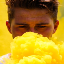

In [24]:
all_imgs[1235] # print a test image

In [25]:
del all_imgs

In [26]:
import gc
gc.collect()

1389

### Augment the data

In [27]:
import imgaug.augmenters as iaa
from pathlib import Path
import cv2
from IPython.display import Image


In [28]:
newseq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
   
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.0),
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-8, 8)
    )
], random_order=True)

In [29]:
def create_aug_names(names: pd.Series, cat: str) -> pd.Series:
    augnames = names.copy()
    for i, name in enumerate(names.values):
        augnames.iloc[i] = "AUG_" + cat + "_" + str(i) + "_" + name
    return augnames


In [30]:
def get_imgs_to_sample(series: pd.Series) -> pd.Series:
    counts = series.value_counts()
    return counts.max() - counts

In [31]:
def create_augs(df: pd.DataFrame, img_to_sample: pd.Series, seq: iaa.Sequential, read_dir, write_dir, colname: str = "age") -> pd.DataFrame:
    new_df = pd.DataFrame()
    for cat, count in img_to_sample.items():
        print(f"Sampling {count} images for {colname} {cat}")
        if count > 0:
            df_sample = df[df[colname] == cat].sample(count, replace=True)
            df_sample["aug_name"] = create_aug_names(df_sample["name"], cat)
            df_sample["aug_cat"] = colname
            sample_imgs = [cv2.imread(read_dir + '/' + name) for name in df_sample["name"]]
            augs = seq.augment_images(sample_imgs)
            for i, aug in enumerate(augs):
                cv2.imwrite(str(write_dir + '/' + df_sample.iloc[i, 5]), aug)
            new_df = pd.concat([new_df, df_sample])
    return new_df


In [32]:
def upsample_imgs(df, sample_cols, seq, read_dir, write_dir):
    aug_df = pd.DataFrame()
    for col in sample_cols:
        print(f"Upsampling {col}")
        counts = df[col].value_counts()
        img_to_sample = 100+counts.max() - counts
        aug_df = pd.concat(
            [
                aug_df,
                create_augs(df, img_to_sample, seq=seq, colname=col, read_dir=read_dir, write_dir=write_dir),
            ]
        )
    return aug_df

In [33]:
labels = pd.read_csv('./train/labels.csv')
labels = labels[labels["real_face"] == 1].dropna()
# don't need to run this every time since the images are generated

#aug_df = upsample_imgs(labels, sample_cols=cat, seq=newseq, read_dir='./train', write_dir='./augmented_train')
#aug_df.to_csv('./augmented_train/labels.csv')

In [34]:
print(labels.shape[0])
print(labels['skin_tone'].value_counts())
print(labels['gender'].value_counts())
print(labels['age'].value_counts())

6019
monk_3     1198
monk_4     1115
monk_5      915
monk_2      890
monk_7      483
monk_6      442
monk_1      358
monk_8      339
monk_9      198
monk_10      81
Name: skin_tone, dtype: int64
female    3581
male      2438
Name: gender, dtype: int64
18_30     2984
31_60     1507
0_17      1334
61_100     194
Name: age, dtype: int64


### Integrate the Augmented Data

In [35]:
# load data
AUGPATH = './augmented_train/'
aug_df = pd.read_csv(AUGPATH+'labels.csv')
df_aug_labeled = aug_df[aug_df["skin_tone"].notna()] # take only labeled data

# Converting labels to np array
aug_Y = []
for i in range(3):
    lab = lbs[i].transform(df_aug_labeled[df_aug_labeled['aug_cat']==cat[i]][cat[i]])
    if lab.shape[1]==1:
        aug_Y.append(np.hstack((1-lab,lab)))
    else:
        aug_Y.append(lab)

In [36]:
# loading and converting data into np array
print("Loading images")
length = width = 64 # size for each input image, increase if you want
aug_nn = [0,0,0]
aug_X = [[],[],[]]

for i in range(3):
    aug_nn[i] = df_aug_labeled[df_aug_labeled['aug_cat']==cat[i]].shape[0]
    imgs = [image.load_img(AUGPATH+df_aug_labeled[df_aug_labeled['aug_cat']==cat[i]].iloc[j]['aug_name'], target_size=(length,width)) for j in range(aug_nn[i])]

    print("Converting images to np array")
    aug_X[i] = np.empty([aug_nn[i], length, width, 3], dtype=float)
    for j in range(aug_nn[i]):
        aug_X[i][j,:] = image.img_to_array(imgs[j])
    aug_X[i] = K.applications.resnet50.preprocess_input(aug_X[i])

Loading images
Converting images to np array
Converting images to np array
Converting images to np array


In [37]:
Y = [[],[],[]]
X = [[],[],[]]

for i in range(len(cat)):
    Y[i] = np.concatenate([base_Y[i], aug_Y[i]])
    X[i] = np.concatenate([base_X[i], aug_X[i]])

nn = base_nn+np.array(aug_nn)

In [38]:
X[0].shape

(12980, 64, 64, 3)

In [39]:
Y[0].sum(axis=0)

array([1298, 1298, 1298, 1298, 1298, 1298, 1298, 1298, 1298, 1298])

In [40]:
del base_X, base_Y
del aug_X, aug_Y

## Specify the Model

We define a single model class that is able train on the data in `X` and `Y` and predict outcomes for all three classes.

In [41]:
class CategoricalDisparity(tf.keras.metrics.Metric):

    def __init__(self, num_classes, name="disparity", **kwargs):
        super(CategoricalDisparity, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes    

        self.acc_max = self.add_weight(name="max", initializer="zeros")
        self.acc_min = self.add_weight(name="min", initializer="zeros")

        self.cm = self.add_weight(name="cm", shape=[num_classes,num_classes], initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.backend.argmax(y_true, axis=-1)
        y_pred = K.backend.argmax(y_pred, axis=-1)
        y_true = K.backend.flatten(y_true)

        new_cm = tf.math.confusion_matrix(y_true,y_pred, num_classes = self.num_classes, dtype=tf.float32)
        
        if (K.backend.int_shape(new_cm) == (self.num_classes, self.num_classes)) and (self.num_classes > 0):
            self.cm.assign_add(new_cm)
        row_sum = K.backend.sum(self.cm, axis=0)
        diag = K.backend.cast(tf.linalg.diag_part(self.cm), dtype=tf.float32)
        accuracies = diag / row_sum
        acc_max = K.backend.max(accuracies)
        acc_min = K.backend.min(accuracies)
        
        self.acc_max.assign(acc_max)
        self.acc_min.assign(acc_min)
        
    def result(self):
        return self.acc_max - self.acc_min
    
    def reset_state(self):
        self.acc_max.assign(0)
        self.acc_min.assign(0)
        self.cm.assign(np.zeros([self.num_classes, self.num_classes], dtype=np.float32))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(CategoricalDisparity, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [42]:
class CategoricalDisparityScore(tf.keras.metrics.Metric):

    def __init__(self, num_classes, name="disparity_score", **kwargs):
        super(CategoricalDisparityScore, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes    

        self.acc_max = self.add_weight(name="max", initializer="zeros")
        self.acc_min = self.add_weight(name="min", initializer="zeros")
        self.score = self.add_weight(name="score", initializer="zeros")

        self.cm = self.add_weight(name="cm", shape=[num_classes,num_classes], initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.backend.argmax(y_true, axis=-1)
        y_pred = K.backend.argmax(y_pred, axis=-1)
        y_true = K.backend.flatten(y_true)

        new_cm = tf.math.confusion_matrix(y_true,y_pred, num_classes = self.num_classes, dtype=tf.float32)
        
        if (K.backend.int_shape(new_cm) == (self.num_classes, self.num_classes)) and (self.num_classes > 0):
            self.cm.assign_add(new_cm)
        row_sum = K.backend.sum(self.cm, axis=0)
        diag = K.backend.cast(tf.linalg.diag_part(self.cm), dtype=tf.float32)
        accuracies = diag / row_sum
        acc_max = K.backend.max(accuracies)
        acc_min = K.backend.min(accuracies)
        
        acc = K.backend.sum(diag)/K.backend.sum(self.cm)

        self.acc_max.assign(acc_max)
        self.acc_min.assign(acc_min)
        
        if (self.num_classes == 2):
          weight = 2
          penalty = 1
        elif (self.num_classes== 10):
          weight = 10
          penalty = 5
        else: 
          weight = 4
          penalty = 2

        self.score.assign(weight * acc * (1 - (self.acc_max - self.acc_min)**penalty))

    def result(self):
        return self.score
    
    def reset_state(self):
        self.acc_max.assign(0)
        self.acc_min.assign(0)
        self.score.assign(0)
        self.cm.assign(np.zeros([self.num_classes, self.num_classes], dtype=np.float32))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(CategoricalDisparityScore, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [43]:
class CategoricalMaxAccuracy(tf.keras.metrics.Metric):

    def __init__(self, num_classes, name="max_accuracy", **kwargs):
        super(CategoricalMaxAccuracy, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes    

        self.acc_max = self.add_weight(name="max", initializer="zeros")
        self.acc_min = self.add_weight(name="min", initializer="zeros")

        self.cm = self.add_weight(name="cm", shape=[num_classes,num_classes], initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.backend.argmax(y_true, axis=-1)
        y_pred = K.backend.argmax(y_pred, axis=-1)
        y_true = K.backend.flatten(y_true)

        new_cm = tf.math.confusion_matrix(y_true,y_pred, num_classes = self.num_classes, dtype=tf.float32)
        
        if (K.backend.int_shape(new_cm) == (self.num_classes, self.num_classes)) and (self.num_classes > 0):
            self.cm.assign_add(new_cm)
        row_sum = K.backend.sum(self.cm, axis=0)
        diag = K.backend.cast(tf.linalg.diag_part(self.cm), dtype=tf.float32)
        accuracies = diag / row_sum
        acc_max = K.backend.max(accuracies)
        acc_min = K.backend.min(accuracies)
        
        self.acc_max.assign(acc_max)
        self.acc_min.assign(acc_min)
        
    def result(self):
        return self.acc_max
    
    def reset_state(self):
        self.acc_max.assign(0)
        self.acc_min.assign(0)
        self.cm.assign(np.zeros([self.num_classes, self.num_classes], dtype=np.float32))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(CategoricalMaxAccuracy, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [44]:
class CategoricalMinAccuracy(tf.keras.metrics.Metric):

    def __init__(self, num_classes, name="min_accuracy", **kwargs):
        super(CategoricalMinAccuracy, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes    

        self.acc_max = self.add_weight(name="max", initializer="zeros")
        self.acc_min = self.add_weight(name="min", initializer="zeros")

        self.cm = self.add_weight(name="cm", shape=[num_classes,num_classes], initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.backend.argmax(y_true, axis=-1)
        y_pred = K.backend.argmax(y_pred, axis=-1)
        y_true = K.backend.flatten(y_true)

        new_cm = tf.math.confusion_matrix(y_true,y_pred, num_classes = self.num_classes, dtype=tf.float32)
        
        self.cm.assign_add(new_cm)
        row_sum = K.backend.sum(self.cm, axis=0)
        diag = K.backend.cast(tf.linalg.diag_part(self.cm), dtype=tf.float32)
        accuracies = diag / row_sum
        acc_max = K.backend.max(accuracies)
        acc_min = K.backend.min(accuracies)
        
        self.acc_max.assign(acc_max)
        self.acc_min.assign(acc_min)
        
    def result(self):
        return self.acc_min
    
    def reset_state(self):
        self.acc_max.assign(0)
        self.acc_min.assign(0)
        self.cm.assign(np.zeros([self.num_classes, self.num_classes], dtype=np.float32))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(CategoricalMinAccuracy, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [45]:
class PredictionModel():
    def __init__(self, X, Y, idx):
        self.X = X
        self.Y = Y
        self.idx = idx
        self.trainX, self.testX = [X[i][idx[0][i],:] for i in range(3)], [X[i][idx[1][i],:] for i in range(3)]
        self.trainY, self.testY = [Y[i][idx[0][i],:] for i in range(3)], [Y[i][idx[1][i],:] for i in range(3)]
        self.cat = ['skin_tone','gender','age']
        self.loss = ['categorical_crossentropy' for i in range(3)]
        self.metrics = [['accuracy', CategoricalDisparity(num_classes=Y[i][idx[0][i],:].shape[1]),
                         CategoricalMaxAccuracy(num_classes=Y[i][idx[0][i],:].shape[1]),
                         CategoricalMinAccuracy(num_classes=Y[i][idx[0][i],:].shape[1]),
                         CategoricalDisparityScore(num_classes=Y[i][idx[0][i],:].shape[1])] for i in range(3)]  # 
        self.models = [None]*3
        self.face_model = [None]

    # train a model specific for a certain class index in self.cat
    def fit(self, index, model, lr = 0.001, epochs=5, batch_size=32, save=False, save_location=None, verbose=1):
        
        if verbose: print("Training model for "+self.cat[index])
        
        model.add(K.layers.Dense(self.trainY[index].shape[1], activation='softmax'))

        opt = tf.keras.optimizers.Adam(lr)
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_disparity_score',
                                                    mode = 'max',
                                                    restore_best_weights = True,
                                                    patience=3)

        model.compile(loss=self.loss[index], optimizer=opt, metrics=self.metrics[index])
        model.fit(
            self.trainX[index], self.trainY[index], 
            validation_data=(self.testX[index],self.testY[index]), 
            batch_size=batch_size, epochs=epochs, verbose=verbose,
            callbacks = [callback]
        )
        
        if save:
            if os.path.exists(SAVEPATH)==False:
                print('save location '+SAVEPATH+' did not exist. creating')
                os.makedirs(SAVEPATH)
            SAVE_LOCATION = save_location+'model_'+cat[index]+'.h5'
            print("saving model at "+SAVE_LOCATION)
            model.save(SAVE_LOCATION)
        
        self.models[index] = model
        
    # train a model which updates loss weights after each epoch
    def custom_fit(self, index, model, epochs=5, batch_size=32, save=False, save_location=None, verbose=1):
        
        if verbose: print("Training custom weight model for "+self.cat[index])
        
        output_categories = self.trainY[index].shape[1]
        counts = self.trainY[index].sum(axis=0)
        
        model.add(K.layers.Dense(output_categories, activation='softmax'))
        
        loss_weights = np.ones(output_categories)/output_categories
        loss_weights = (loss_weights / counts) / np.sum(loss_weights / counts)
        opt = tf.keras.optimizers.Adam(0.001)
        
        for i in range(epochs):
            print(f"Epoch {i+1}/{epochs}")
            class_weights = dict(enumerate(loss_weights))
            model.compile(loss=self.loss[index], optimizer=opt, metrics=self.metrics[index])
        
            model.fit(
                self.trainX[index], self.trainY[index], 
                validation_data=(self.testX[index],self.testY[index]), 
                batch_size=batch_size, epochs=1, verbose=verbose,
                class_weight = class_weights
            )

            predy = np.argmax(model.predict(self.trainX[index]),1)
            truey = np.argmax(self.trainY[index],1)
            cats = max(truey) + 1
            accs = np.zeros(cats)
            for i in range(cats):
                accs[i] = np.sum((predy==truey) & (truey==i))/np.sum(truey==i)
            epsilon = 1
            
            loss_weights = (1/(accs + epsilon))
            loss_weights = (loss_weights) / np.sum(loss_weights)
            print(np.round(accs,2))
            print(np.round(loss_weights,2))
            
        if save:
            if os.path.exists(SAVEPATH)==False:
                print('save location '+SAVEPATH+' did not exist. creating')
                os.makedirs(SAVEPATH)
            SAVE_LOCATION = save_location+'custommodel_'+cat[index]+'.h5'
            print("saving model at "+SAVE_LOCATION)
            model.save(SAVE_LOCATION)
        
        self.models[index] = model
            
    def predict(self, newX):
        face_detect = self.face_model[0].predict(newX)
        faces = np.argmax(face_detect,axis=1)
        predictions = [np.argmax(model.predict(newX),axis=1) for model in self.models]
        num_classes = [10,2,4]
        clean_preds = []
        for i in range(3):
          clean_preds.append([np.random.randint(num_classes[i]) if (faces[j] == 0) else predictions[i][j] for j in range(predictions[i].shape[0])])
        return clean_preds

    def load(self, folder='/content/drive/MyDrive/face_bounty/models/', paths=['skin_tone.h5','gender.h5','age.h5'], face_path='face_detect.h5'):
        custom_objects={"CategoricalDisparity": CategoricalDisparity,
                  "CategoricalDisparityScore": CategoricalDisparityScore,
                  "CategoricalMinAccuracy": CategoricalMinAccuracy,
                  "CategoricalMaxAccuracy": CategoricalMaxAccuracy,
                  }
        for i in range(3):
           self.models[i] = K.models.load_model(folder+paths[i], custom_objects=custom_objects)

        self.face_model[0] = K.models.load_model(folder+face_path)

## Initialize and Train a Model

We now train a `PredictionModel` to predict the likely skin tone, gender, and age of an input image. This baseline model is initialize on imagenet weights and uses the ResNet50 architecture. We strongly recommend using a GPU to reduce training time.

In [46]:
# function to initialize a model
def initializeModel():
    res_model = ResNet50(include_top=False, weights='imagenet', input_tensor=K.Input(shape=[length,width,3]))

    # freeze all but the last layer
    for layer in res_model.layers[:143]:
        layer.trainable = False
    model = K.models.Sequential()
    model.add(res_model)
    model.add(K.layers.Flatten())
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(512, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(512, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    return model

nntrain = [[],[],[]]
indices = [[],[],[]]
train_idx = [[],[],[]]
test_idx = [[],[],[]]

for i in range(3):
    nntrain[i] = int(0.7*nn[i])
    np.random.seed(42)
    indices = np.random.permutation(nn[i])
    train_idx[i], test_idx[i] = indices[:nntrain[i]], indices[nntrain[i]:]



In [34]:
#del mymodel

In [35]:
mymodel = PredictionModel(X=X, Y=Y, idx=[train_idx,test_idx])

In [36]:
# train model
mymodel.fit(index=0, model=initializeModel(), lr = 0.001, epochs=20, save=False,
            save_location='./content/drive/MyDrive/face_bounty/models/')

Training model for skin_tone
Epoch 1/20
284/284 [==============================] - 30s 57ms/step - loss: 2.4413 - accuracy: 0.1884 - disparity: 0.1541 - max_accuracy: 0.2702 - min_accuracy: 0.1161 - disparity_score: 1.8841 - val_loss: 5.6749 - val_accuracy: 0.2375 - val_disparity: 0.1834 - val_max_accuracy: 0.3557 - val_min_accuracy: 0.1723 - val_disparity_score: 2.3750
Epoch 2/20
284/284 [==============================] - 13s 45ms/step - loss: 2.0114 - accuracy: 0.2601 - disparity: 0.1995 - max_accuracy: 0.3791 - min_accuracy: 0.1796 - disparity_score: 2.5999 - val_loss: 3.4806 - val_accuracy: 0.2992 - val_disparity: 0.3427 - val_max_accuracy: 0.4965 - val_min_accuracy: 0.1538 - val_disparity_score: 2.9776
Epoch 3/20
284/284 [==============================] - 13s 45ms/step - loss: 1.7911 - accuracy: 0.3133 - disparity: 0.2249 - max_accuracy: 0.4678 - min_accuracy: 0.2430 - disparity_score: 3.1316 - val_loss: 2.1401 - val_accuracy: 0.3480 - val_disparity: 0.2560 - val_max_accuracy: 0.5

In [37]:
mymodel.models[0].save('/content/drive/MyDrive/face_bounty/models/skin_tone.h5')

In [39]:
# train model
mymodel.fit(index=1, model=initializeModel(), lr = 0.001, epochs=20, save=False,
            save_location='./content/drive/MyDrive/face_bounty/models/')

Training model for gender
Epoch 1/20
162/162 [==============================] - 15s 65ms/step - loss: 0.5912 - accuracy: 0.7504 - disparity: 0.0046 - max_accuracy: 0.7528 - min_accuracy: 0.7482 - disparity_score: 1.4940 - val_loss: 0.7037 - val_accuracy: 0.8180 - val_disparity: 0.0140 - val_max_accuracy: 0.8254 - val_min_accuracy: 0.8114 - val_disparity_score: 1.6131
Epoch 2/20
162/162 [==============================] - 7s 45ms/step - loss: 0.3963 - accuracy: 0.8304 - disparity: 0.0094 - max_accuracy: 0.8351 - min_accuracy: 0.8257 - disparity_score: 1.6452 - val_loss: 0.5953 - val_accuracy: 0.8067 - val_disparity: 0.1342 - val_max_accuracy: 0.8897 - val_min_accuracy: 0.7555 - val_disparity_score: 1.3969
Epoch 3/20
162/162 [==============================] - 7s 45ms/step - loss: 0.2851 - accuracy: 0.8853 - disparity: 0.0039 - max_accuracy: 0.8873 - min_accuracy: 0.8833 - disparity_score: 1.7637 - val_loss: 0.4217 - val_accuracy: 0.8302 - val_disparity: 0.0967 - val_max_accuracy: 0.8842 -

In [40]:
mymodel.models[1].save('/content/drive/MyDrive/face_bounty/models/gender.h5')

In [41]:
# train model
mymodel.fit(index=2, model=initializeModel(), epochs=20, save=False, save_location='./models/test/base/')

Training model for age
Epoch 1/20
270/270 [==============================] - 21s 60ms/step - loss: 1.1995 - accuracy: 0.5429 - disparity: 0.2826 - max_accuracy: 0.6658 - min_accuracy: 0.3832 - disparity_score: 1.9983 - val_loss: 1.0372 - val_accuracy: 0.6242 - val_disparity: 0.3003 - val_max_accuracy: 0.8225 - val_min_accuracy: 0.5221 - val_disparity_score: 2.2714
Epoch 2/20
270/270 [==============================] - 13s 47ms/step - loss: 0.8447 - accuracy: 0.6565 - disparity: 0.2955 - max_accuracy: 0.7939 - min_accuracy: 0.4984 - disparity_score: 2.3967 - val_loss: 0.8567 - val_accuracy: 0.6785 - val_disparity: 0.2710 - val_max_accuracy: 0.8347 - val_min_accuracy: 0.5637 - val_disparity_score: 2.5145
Epoch 3/20
270/270 [==============================] - 13s 46ms/step - loss: 0.6884 - accuracy: 0.7247 - disparity: 0.2571 - max_accuracy: 0.8549 - min_accuracy: 0.5978 - disparity_score: 2.7073 - val_loss: 0.8047 - val_accuracy: 0.6947 - val_disparity: 0.2362 - val_max_accuracy: 0.8392 - 

In [42]:
mymodel.models[2].save('/content/drive/MyDrive/face_bounty/models/age.h5')

## Face Recognizer


In [4]:
# load data
LOADPATH = './train/'
SAVEPATH = './models/limited/'
df = pd.read_csv(LOADPATH+'labels.csv')

df_labeled = df[df["real_face"].notna()] # take only labeled data


In [5]:
# loading and converting data into np array
print("Loading images")
base_nn = df_labeled.shape[0]
all_imgs = [image.load_img(LOADPATH+df_labeled.iloc[i]['name'], target_size=(64,64)) for i in range(base_nn)]

print("Converting images to np array")
face_X = np.empty([base_nn, 64, 64, 3], dtype=float)
for i in range(base_nn):
    face_X[i,:] = image.img_to_array(all_imgs[i])
face_X = K.applications.resnet50.preprocess_input(face_X)

Loading images
Converting images to np array


In [6]:
# Converting labels to np array
face_lbs = LabelBinarizer()

face_lab = face_lbs.fit_transform(df_labeled['real_face'])

face_Y = np.hstack((1-face_lab,face_lab))


In [7]:
nntrain = int(0.7*base_nn)
np.random.seed(42)
indices = np.random.permutation(base_nn)
face_train_idx, face_test_idx = indices[:nntrain], indices[nntrain:]

In [11]:
face_model = initializeModel()

face_model.add(K.layers.Dense(2, activation='softmax'))

opt = tf.keras.optimizers.Adam(0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            mode = 'min',
                                            restore_best_weights = True,
                                            patience=3)

face_model.compile(loss='categorical_crossentropy', optimizer=opt)


face_model.fit(
    face_X[face_train_idx], face_Y[face_train_idx], 
    validation_data=(face_X[face_test_idx],face_Y[face_test_idx]), 
    batch_size=32, epochs=20,
    callbacks = [callback]
)

Epoch 1/20
269/269 [==============================] - 26s 47ms/step - loss: 0.2427 - val_loss: 0.2312
Epoch 2/20
269/269 [==============================] - 11s 39ms/step - loss: 0.1601 - val_loss: 0.1275
Epoch 3/20
269/269 [==============================] - 10s 39ms/step - loss: 0.1142 - val_loss: 0.1222
Epoch 4/20
269/269 [==============================] - 10s 38ms/step - loss: 0.0974 - val_loss: 0.1288
Epoch 5/20
269/269 [==============================] - 10s 38ms/step - loss: 0.0658 - val_loss: 0.1414
Epoch 6/20
269/269 [==============================] - 10s 38ms/step - loss: 0.0546 - val_loss: 0.1681


In [12]:
face_model.save('/content/drive/MyDrive/face_bounty/models/face_detect.h5')

## Evaluate the Model

We now evaluate the model on the test data. To do this, let's first load up that data and structure it similarly.

In [51]:
# load labels data
TESTPATH = './test/'
df_test = pd.read_csv(TESTPATH+'labels.csv')

# Convert labels to np array
print("Converting test labels to np array")
testY = []
for i in range(3):
    lab = lbs[i].fit_transform(df_test[cat[i]])
    if lab.shape[1]==1:
        testY.append(np.hstack((1-lab,lab)))
    else:
        testY.append(lab)
        
# load and convert images into np array
print("Loading test images")
nt = df_test.shape[0]
all_imgs = [image.load_img(TESTPATH+df_test.iloc[i]['name'], target_size=(length,width)) for i in range(nt)]

print("Converting test images to np array")
testX = np.empty([nt, length, width, 3], dtype=float)
for i in range(nt):
    testX[i,:] = image.img_to_array(all_imgs[i])
testX = K.applications.resnet50.preprocess_input(testX)

Converting test labels to np array
Loading test images
Converting test images to np array


In [65]:
face_indices = df_test['real_face'][:1000] == 1
fake_indices = df_test['real_face'][:1000] != 1

We also need to reload the model:

In [43]:
if False:
  loaded_models = [[],[],[]]
  pred = [[],[],[]]

  custom_objects = {"CategoricalDisparity": CategoricalDisparity, "CategoricalMaxAccuracy": CategoricalMaxAccuracy, "CategoricalMinAccuracy":CategoricalMinAccuracy}
  for i in range(3):
      models[i] = K.models.load_model('./models/test/base/' + 'model_'+cat[i]+'.h5', custom_objects=custom_objects)
      pred[i] = models[i].predict(testX[i])    
    
      predY = [[np.argmax(pred[i][j,:]) for j in range(nt)] for i in range(3)]

We then obtain predicted labels for skin tone, gender, and age as a list of lists.

In [44]:
pred = mymodel.predict(testX)
predY = [[np.argmax(pred[i][j,:]) for j in range(nt)] for i in range(3)]
predLabels = [[lbs[i].classes_[j] for j in predY[i]] for i in range(3)]

94/94 [==============================] - 2s 16ms/step


Finally, we calculate the label-wise accuracy and disparity.

In [55]:
# calculate accuracy
acc = {}
for i in range(3):
    icat = cat[i]
    iacc = accuracy_score(df_test[cat[i]], predLabels[i])
    acc[icat] = iacc
    
# calculate disparity
def disparity_score(ytrue, ypred):
    cm = confusion_matrix(ytrue,ypred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    all_acc = list(cm.diagonal())
    return max(all_acc) - min(all_acc)

disp = {}
for i in range(3):
    icat = cat[i]
    idisp = disparity_score(df_test[cat[i]], predLabels[i])
    disp[icat] = idisp
disp

results = {'accuracy': acc, 'disparity': disp}
results

{'accuracy': {'skin_tone': 0.23033333333333333,
  'gender': 0.7496666666666667,
  'age': 0.5523333333333333},
 'disparity': {'skin_tone': 0.2030581039755352,
  'gender': 0.08000139484604396,
  'age': 0.3795038293557254}}

In [68]:
import scipy.stats as stats

true_acc = {}
for i in range(3):
    icat = cat[i]
    iacc = accuracy_score(df_test[:1000][face_indices.values][cat[i]], np.array(predLabels[i])[:1000][face_indices.values])
    true_acc[icat] = iacc

fake_acc = {}
for i in range(3):
    icat = cat[i]
    obs = pd.Series(predLabels[i][:1000])[fake_indices.values].value_counts().values
    e = obs.sum()/len(obs)
    chi2 = ((obs - e)**2 / e).sum()
    iacc = 1 - stats.chi2.cdf(chi2, df=len(obs)-1)
    fake_acc[icat] = iacc


In [69]:
print({'true_accuracy': true_acc, 'fake_chi': fake_acc})

{'true_accuracy': {'skin_tone': 0.25934579439252337, 'gender': 0.8271028037383178, 'age': 0.6238317757009346}, 'fake_chi': {'skin_tone': 0.9335344885888095, 'gender': 0.6170750774519739, 'age': 0.9188914116546758}}


skin_tone


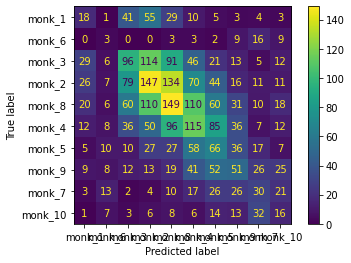

gender


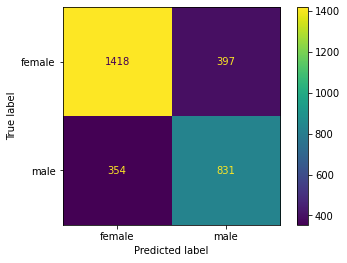

age


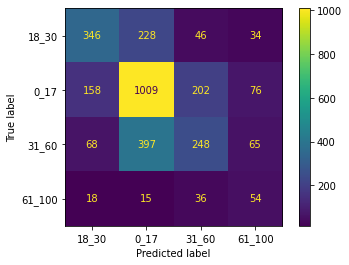

In [58]:
import matplotlib.pyplot as plt

for i in range(3):
    labels = df[df[cat[i]].notna()][cat[i]].unique()
    print(cat[i])
    ConfusionMatrixDisplay(confusion_matrix(df_test[cat[i]], predLabels[i]),display_labels=labels).plot()
    plt.show()

# Score Model and Prepare Submission

Based on the above metric, we now calculate the score to evaluate your submission. This score will be displayed in your public leaderboard.

In [70]:
def getScore(results):
    acc = results['accuracy']
    disp = results['disparity']
    ad = 2*acc['gender']*(1-disp['gender']) + 4*acc['age']*(1-disp['age']**2) + 10*acc['skin_tone']*(1-disp['skin_tone']**5)
    return ad

title = 'OIICrew'
    
submission = {
    'submission_name': title,
    'score': getScore(results),
    'metrics': results
}

   
submission

{'submission_name': 'OIICrew',
 'score': 5.573060914433677,
 'metrics': {'accuracy': {'skin_tone': 0.23033333333333333,
   'gender': 0.7496666666666667,
   'age': 0.5523333333333333},
  'disparity': {'skin_tone': 0.2030581039755352,
   'gender': 0.08000139484604396,
   'age': 0.3795038293557254}}}

Finally, let's export this as a json file to upload as part of filling out your [submission form](https://docs.google.com/forms/d/e/1FAIpQLSfwqtVkJBVRP6TnFp7vHbbH8SlwKZJFIjvGQy7TyYFc8HR1hw/viewform).

In [71]:
with open("model_score.json", "w") as f:
    json.dump(submission, f, indent=4)

## Reload Model from Saved File


In [47]:
loadmodel = PredictionModel(X=X, Y=Y, idx=[train_idx,test_idx])

In [49]:
loadmodel.load(folder = '/content/drive/MyDrive/face_bounty/models/')

In [53]:
pred = loadmodel.predict(testX)
#predY = [[np.argmax(pred[i],axis=1)] for i in range(3)]
#predLabels = [[lbs[i].classes_[j] for j in predY[i]] for i in range(3)]

94/94 [==============================] - 3s 15ms/step


In [54]:
predLabels = [[lbs[i].classes_[j] for j in pred[i]] for i in range(3)]

In [61]:
faces = loadmodel.face_model[0].predict(testX)

94/94 [==============================] - 2s 16ms/step


In [64]:
faces = np.argmax(faces,axis=1)

In [ ]:
confusion_matrix()